In [1]:
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html  
import streamlit as st

C:\Users\ti_ag\AppData\Local\Temp\ipykernel_26920\4130196011.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table
C:\Users\ti_ag\AppData\Local\Temp\ipykernel_26920\4130196011.py:9: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
# Importando os dados
df_exp_vinhos  = pd.read_csv('Data/output/exportacao_vinhos.csv', encoding="utf-8")
df_meteorologia_ano = pd.read_csv('Data/output/Meteorologia_Ano_mediana.csv')
df_inflacao = pd.read_csv('Data/output/inflacao_brasil.csv', sep=';', encoding="utf-8")
df_pib_br = pd.read_csv('Data/output/pib_brasil.csv', sep=';', encoding="utf-8")
df_pib_rs = pd.read_csv('Data/output/pib_rs.csv', sep=';', encoding="utf-8")
df_dolar = pd.read_csv('Data/output/dolar_mediana_ano.csv', encoding="utf-8")
df_producao = pd.read_csv('Data/output/Producao.csv')

In [3]:
# Renomeando colunas
df_pib_br = df_pib_br.rename(columns={'Valor': 'PIB_Brasil_Trilhoes'})
df_pib_rs = df_pib_rs.rename(columns={'Valor': 'PIB_RS_Trilhoes'})

In [4]:
# Convertendo os valores para int de Ano nas tabelas de exportação de vinhos e meteorologia
df_exp_vinhos['Ano'] = df_exp_vinhos['Ano'].astype(int)
df_meteorologia_ano['Ano'] = df_meteorologia_ano['Ano'].astype(int)
df_dolar['Ano'] = df_dolar['Ano'].astype(int)

In [5]:
# Convertendo os valores para float de Inflação e PIB nas tabelas de inflação e PIB
df_inflacao['Inflação'] = df_inflacao['Inflação'].astype(str).str.replace(',', '.').astype(float)
df_pib_br['PIB_Brasil_Trilhoes'] = df_pib_br['PIB_Brasil_Trilhoes'].astype(str).str.replace(',', '.').astype(float)
df_pib_rs['PIB_RS_Trilhoes'] = df_pib_rs['PIB_RS_Trilhoes'].astype(str).str.replace(',', '.').astype(float)

In [6]:
# Ajusando escala do de valores
df_pib_br['PIB_Brasil_Trilhoes'] = (df_pib_br['PIB_Brasil_Trilhoes'] / 1e12).round(3)
df_pib_rs['PIB_RS_Trilhoes'] = (df_pib_rs['PIB_RS_Trilhoes'] / 1e12).round(3)

In [7]:
# União dos dataframes de exportação de vinhos e meteorologia
df_unificado = df_exp_vinhos.merge(df_meteorologia_ano[['Ano', 'TempAr', 'Precipitacao']], on='Ano')

In [8]:
# União do dataframe unificado com a inflação
df_unificado = df_unificado.merge(df_inflacao[['Ano', 'Inflação']], on='Ano')

In [9]:
# União do dataframe unificado com o PIB do Brasil
df_unificado = df_unificado.merge(df_pib_br[['Ano', 'PIB_Brasil_Trilhoes']], on='Ano')

In [10]:
# União do dataframe unificado com o PIB do RS
df_unificado = df_unificado.merge(df_pib_rs[['Ano', 'PIB_RS_Trilhoes']], on='Ano')

In [11]:
# União do dataframe unificado com o dolar
df_unificado = df_unificado.merge(df_dolar[['Ano', 'USD BRL']], on='Ano')

In [12]:
# Ordenando o dataframe por Ano e Pais
df_unificado = df_unificado.sort_values(by=['Ano'])

In [13]:
# Calculando o valor por litro
df_unificado['ValorPorLitro'] = (df_unificado['Valor'] / df_unificado['Litros']).round(2)

In [14]:
# pega o maior ano
max_ano = df_unificado['Ano'].max()

# usando a max_ano, pegar os ultimos 15 anos
df_unificado_ultimos_anos = df_unificado[df_unificado['Ano'] > max_ano - 15]

In [15]:
# A soma da coluna 'Valor' agrupando por 'Ano' e 'Pais'
df_soma_valor = df_unificado_ultimos_anos.groupby(['Ano', 'País'])['Valor'].sum().reset_index()


In [16]:
# top 10 paises
df_top_10_paises = df_soma_valor.groupby('País')['Valor'].sum().nlargest(10).reset_index()

In [17]:
# em df_unificado_ultimos_anos filtrar com base nos top 10 paises
df_unificado_ultimos_anos_top_10_paises = df_unificado_ultimos_anos[df_unificado_ultimos_anos['País'].isin(df_top_10_paises['País'])]

2024-05-25 16:35:41.209 
  command:

    streamlit run c:\Users\ti_ag\source\repo\PROJETO\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

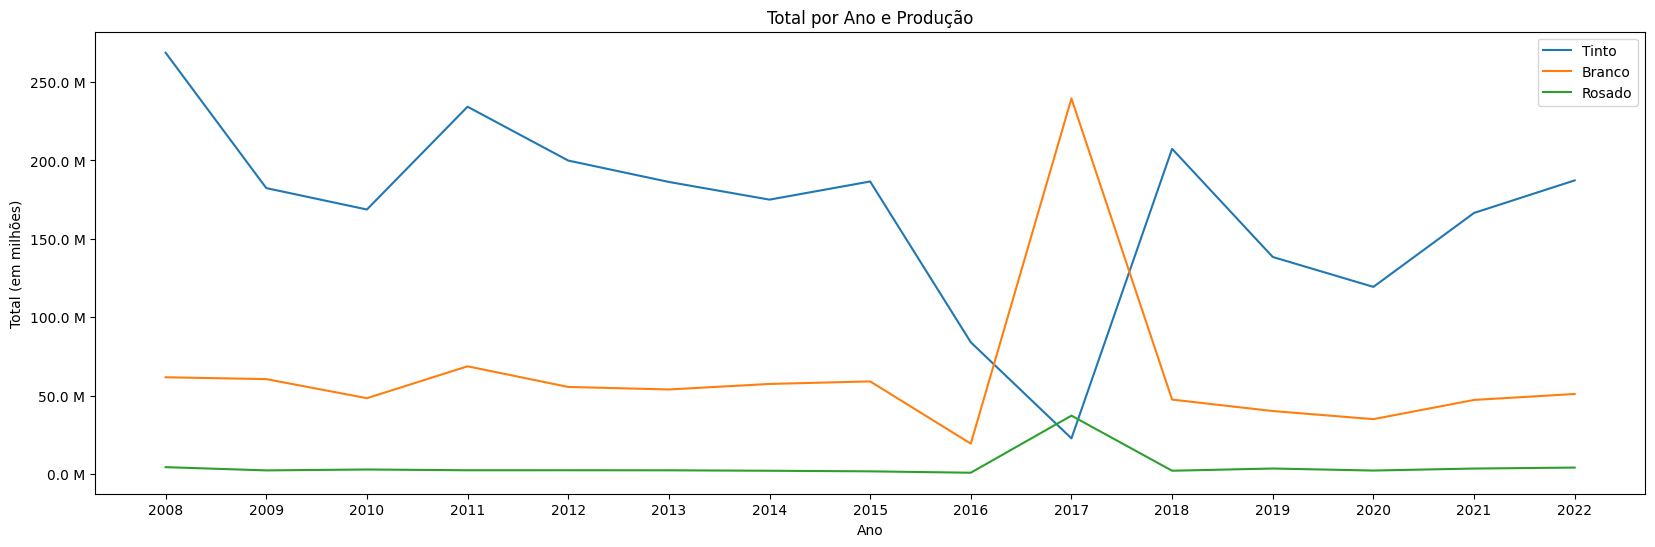

In [18]:
# Producao

# Filtrando os dados de produção de vinho
df_producao_vinho = df_producao[(df_producao['Tipo'] == 'vinho de mesa') | (df_producao['Tipo'] == 'vinho fino de mesa (vinífera)')]

# Agrupando por produto e somando os valores por ano
df_producao_soma = df_producao_vinho.groupby('Produto').sum()

# somar o valor das 15 ultimas colunas em total
df_producao_soma['Total_ultimos_15_anos'] = df_producao_soma.iloc[:, -15:].sum(axis=1)

# top 15 paises
df_producao_soma = df_producao_soma.sort_values(by='Total_ultimos_15_anos', ascending=False).head(15)
df_producao_soma = df_producao_soma.drop(columns='Total_ultimos_15_anos')

# Definindo os anos
anos = df_producao_soma.columns[-15:]

# Plotando os dados
fig, ax = plt.subplots(figsize=(20,6))

for item in df_producao_soma.index:
    plt.plot(anos, df_producao_soma.loc[item, anos] / 1_000_000, label=item)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f} M'))

plt.xlabel('Ano')
plt.ylabel('Total (em milhões)')
plt.title('Total por Ano e Produção')
plt.legend()

# plt.show()
st.pyplot(fig)

In [19]:
df_unificado_ultimos_anos_top_10_paises.iloc[0]

País                   Países Baixos
Ano                             2009
Litros                      171654.0
Valor                       136991.0
TempAr                          18.2
Precipitacao                     0.8
Inflação                        4.31
PIB_Brasil_Trilhoes            3.333
PIB_RS_Trilhoes                0.204
USD BRL                       1.9439
ValorPorLitro                    0.8
Name: 374, dtype: object

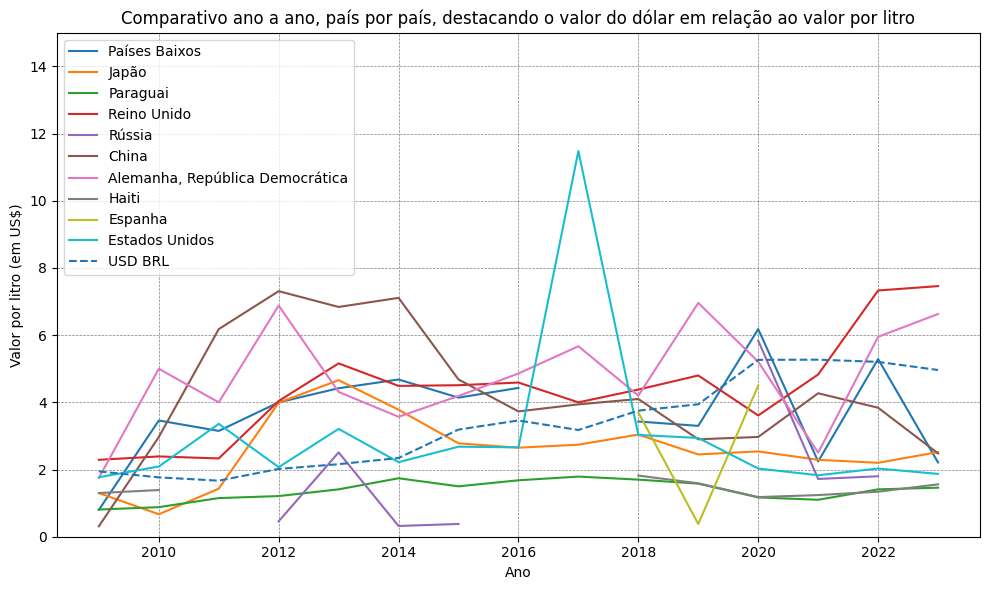

In [20]:
# Lista de países únicos no DataFrame
paises = df_unificado_ultimos_anos_top_10_paises['País'].unique()

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
# Cria uma linha para cada país
for pais in paises:
    df_pais = df_unificado_ultimos_anos_top_10_paises[df_unificado_ultimos_anos_top_10_paises['País'] == pais]
    plt.plot(df_pais['Ano'], df_pais['ValorPorLitro'], label=pais)

# Adiciona a linha do valor do dólar
plt.plot(df_pais['Ano'], df_pais['USD BRL'], label='USD BRL', linestyle='--')

plt.title('Comparativo ano a ano, país por país, destacando o valor do dólar em relação ao valor por litro') 
plt.xlabel('Ano')
plt.ylabel('Valor por litro (em US$)')

# Diminui o tamanho dos rótulos do eixo y
plt.ylim(0, 15)

# Adiciona uma legenda
plt.legend()

plt.tight_layout()

plt.show()

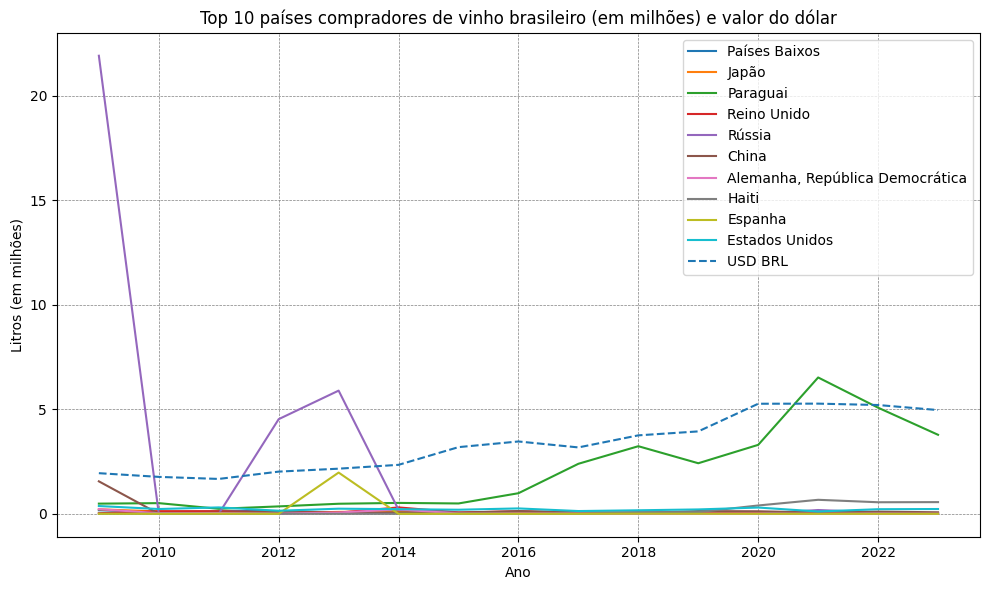

In [21]:
# Lista de países únicos no DataFrame
paises = df_unificado_ultimos_anos_top_10_paises['País'].unique()

plt.figure(figsize=(10, 6))

# Cria uma linha para cada país
for pais in paises:
    df_pais = df_unificado_ultimos_anos_top_10_paises[df_unificado_ultimos_anos_top_10_paises['País'] == pais]
    plt.plot(df_pais['Ano'], df_pais['Litros'] / 1_000_000, label=pais)

# Adiciona a linha do valor do dólar
plt.plot(df_pais['Ano'], df_pais['USD BRL'], label='USD BRL', linestyle='--')

plt.title('Top 10 países compradores de vinho brasileiro (em milhões) e valor do dólar')
plt.xlabel('Ano')
plt.ylabel('Litros (em milhões)')

# Adiciona uma legenda
plt.legend()

plt.tight_layout()

plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.show()

In [22]:
# filtrar com maior ano da base
df_unificado_ultimos_anos_top_10_paises_max_ano= df_unificado_ultimos_anos_top_10_paises[df_unificado_ultimos_anos_top_10_paises['Ano'] == max_ano]

In [23]:
# adicionar a coluna valor do df_top_10_paises e renomear a coluna 
df_top_10_paises = df_top_10_paises.rename(columns={'Valor': 'Valor_Total_Ultimos_Anos'})
df_unificado_ultimos_anos_top_10_paises_max_ano = df_unificado_ultimos_anos_top_10_paises_max_ano.merge(df_top_10_paises, on=['País'])

In [26]:
df = df_unificado_ultimos_anos_top_10_paises_max_ano

# Renomeando colunas
df = df.rename(columns={'Valor': 'Valor (US$)'})
df = df.rename(columns={'TempAr': 'Temperatura Média (°C)'})
df = df.rename(columns={'Precipitacao': 'Precipitação (mm)'})
df = df.rename(columns={'Inflação': 'Inflação (%)'})
df = df.rename(columns={'PIB_Brasil_Trilhoes': 'PIB Brasil (Trilhões R$)'})
df = df.rename(columns={'PIB_RS_Trilhoes': 'PIB RS (Trilhões R$)'})
df = df.rename(columns={'ValorPorLitro': 'Valor por Litro (US$)'})
df = df.rename(columns={'Valor_Total_Ultimos_Anos': 'Valor Compra Ultimos 15 Anos (US$)'})

df['Valor (US$)'] = df['Valor (US$)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Temperatura Média (°C)'] = df['Temperatura Média (°C)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Precipitação (mm)'] = df['Precipitação (mm)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Inflação (%)'] = df['Inflação (%)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['PIB Brasil (Trilhões R$)'] = df['PIB Brasil (Trilhões R$)'].map('{:,.3f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['PIB RS (Trilhões R$)'] = df['PIB RS (Trilhões R$)'].map('{:,.3f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Valor por Litro (US$)'] = df['Valor por Litro (US$)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['USD BRL'] = df['USD BRL'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Litros'] = df['Litros'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')
df['Valor Compra Ultimos 15 Anos (US$)'] = df['Valor Compra Ultimos 15 Anos (US$)'].map('{:,.2f}'.format).str.replace('.', '#').str.replace(',', '.').str.replace('#', ',')


app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

table = dash_table.DataTable(
    id='table',
    columns=[{"name": i, "id": i} for i in df.columns],
    data=df.to_dict('records'),
    style_table={'overflowX': 'auto'},
    style_cell_conditional=[
        {'if': {'column_id': df.columns[0]},
         'textAlign': 'left'}
    ]
)

app.layout = dbc.Container(
    [
        dbc.Row(
            dbc.Col(html.H3("Top 10 Países que mais compraram vinhos do Brasil nos ultimos 15 anos"),
                    width={'size': 8, 'offset': 4},
                    ),
            ),
        dbc.Row(
            dbc.Col(table),
            ),
    ],
    fluid=True,
)

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [ ]:
# Salvando o dataframe unificado
df_unificado.to_csv('Data/output/base_final.csv', index=False)